<a href="https://colab.research.google.com/github/hank199599/data_science_from_scratch_reading_log/blob/main/Chapter21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 自然語言處理(NLP,Nature Language Process)
指的是一些與自然語言相關的計算技術

# 單詞雲 (word clouds)
根據單詞出現的次數，來決定字體的大小。

In [1]:
data = [("big data",100,15),("Hadoop",95,25),("Python",75,50),("R",50,40),("machine learning",80,20),("statistics",20,60),("data science",60,70),("analytics",90,3),("team player",85,85),("dynamic",2,90),("synergies",70,0),("actionable insights",40,30),("think out of box",45,10),("self-starter",30,50),("customer focus",65,15),("thought leadership",35,35)]

### 圖 21-1 一個由流行語所組成的單詞雲

In [2]:
!pip3 install wordcloud

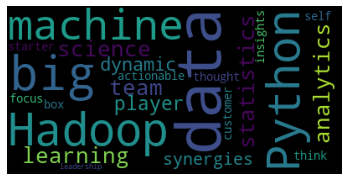

In [3]:
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text=""

for word in data:
  text=text+" "+word[0]

#for word in array:
cloud = WordCloud().generate(text)
plt.imshow(cloud)
plt.axis("off")
plt.show()

### 圖 21-2 一個較有意義的單詞雲

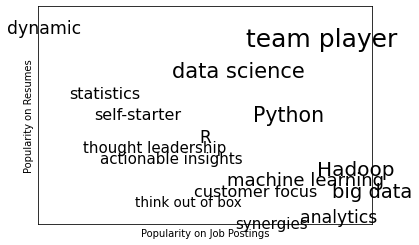

In [4]:
from matplotlib import pyplot as plt

def text_size(total:int) ->float:
  """如果total是0就送出8，如果total是200就送出28"""
  return 8+total/200*20

for word,job_popularity,resume_popularity in data:
  plt.text(job_popularity,resume_popularity,word,ha="center",va="center",size=text_size(job_popularity+resume_popularity))

plt.xlabel("Popularity on Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0,100,0,100])
plt.xticks([])
plt.yticks([])
plt.show()

# N-gram 語言模型
找出一堆文件語料庫，然後學習語言的統計模型

## 2-gram (bigram)
1. 針對某個起始單詞，查出原始文件中皆在這個單詞後面的所有單詞
2. 自其中隨機選擇一個做為下一個單詞
3. 重複這個動作(1. 2.)直到選中代表句子結束的句號。

In [5]:
def fix_unicode(text:str) ->str:
  return text.replace(u"\u2019","'")

In [6]:
import re
from bs4 import BeautifulSoup
import requests

url = "https://www.oreilly.com/ideas/what-is-data-science"
html = requests.get(url).text
soup = BeautifulSoup(html,'html5lib')

content = soup.find("div","main-post-radar-content")
regex = r"[\w']+|[\.]"

document = []

for paragraph in content("p"):
  words = re.findall(regex,fix_unicode(paragraph.text))
  document.extend(words)

只要其中一個輸入項無資料則結束壓縮，  
運用zip(document,doucment[1:])即可精確取得整個文件的連續單詞對

In [7]:
from collections import defaultdict

transitions = defaultdict(list)
for prev,current in zip(document,document[1:]):
  transitions[prev].append(current)

製作出一些句子

In [8]:
import random

def generate_using_bigrams() ->str:
  current = "." #表示下一個單詞將會是某個句子的起始單詞
  result = []
  while True:
    next_word_candidates = transitions[current]  # bigrams (current,_)
    current = random.choice(next_word_candidates) # 隨機挑選其中一個
    result.append(current)              # 添加至結果後面
    if current == ".":return " ".join(result) # 若遇到「.」就完成了


In [9]:
generate_using_bigrams()

'93 percent annual growth of which are designed for exploring and LinkedIn .'

## 3-gram (trigram)

In [10]:
trigram_transitions = defaultdict(list)
starts = []

for prev,current,next in zip(document,document[1:],document[2:]):

  if prev == ".":
    starts.append(current)
  
  trigram_transitions[(prev,current)].append(next)

In [11]:
def generate_using_trigrams() ->str:
  current = random.choice(starts)
  prev = "."
  result = [current]
  while True:
    next_word_candidates = trigram_transitions[(prev,current)]
    next_word = random.choice(next_word_candidates)

    prev,current = current , next_word
    result.append(current)

    if current == ".":
      return " ".join(result)

In [12]:
generate_using_trigrams()

'â Data Mashups in Râ analyzes mortgage foreclosures in Philadelphia County by taking a public report from the data rather than computer science at Stanford with hundreds of students this video is highly recommended .'

# 文法
運用詞性定義一些稍微複雜的文法規則

In [13]:
from typing import List,Dict
 
# 此型別別名在隨後的文法規則中就會用到
Grammar = Dict[str,List[str]]

grammer = {
    "_S":["_NP _VP"],
    "_NP":["_N","_A _NP _P _A _N"],
    "_VP":["_V","_V _NP"],
    "_N":["data science","Python","regression"],
    "_A":["big","linear","logistic"],
    "_P":["about","near"],
    "_V":["learns","trains","tests","is"]
}

In [14]:
def is_terminal(token:str) ->bool:
  return token[0] != "_"

In [15]:
def expand(grammar:Grammar,tokens:List[str]) ->List[str]:
  for i,token in enumerate(tokens):
    # 跳過終端文字
    if is_terminal(token):continue

    # 如果遇到一個非終端文字
    # 就必須隨機挑選一個對應項目來取而代之
    replacement = random.choice(grammar[token])

    if is_terminal(replacement):
      tokens[i] = replacement
    else:
      # 取代的內容有可能是類似 "_NP _VP" 這樣的東西
      # 如此一來，我們必須以空格進行切分，再一一接到後面去
      tokens = tokens[:i] + replacement.split() + tokens[(i+1):]
    
    # 現在，再透過新的token列表，遞迴呼叫 expand 函式
    return expand(grammar,tokens)
  
  #如果全部都是都是終端文字，工作就完成了
  return tokens

生成句子

In [16]:
def generate_sentence(grammar:Grammar) ->List[str]:
  return expand(grammar,["_S"])

In [17]:
generate_sentence(grammer)

['logistic',
 'linear',
 'big',
 'linear',
 'data science',
 'near',
 'logistic',
 'regression',
 'about',
 'logistic',
 'regression',
 'about',
 'linear',
 'data science',
 'about',
 'linear',
 'Python',
 'trains',
 'data science']

# Gibbs 取樣
針對**多維分布**進行取樣的一種技術

In [18]:
from typing import Tuple
import random

def roll_a_die() ->int:
  return random.choice([1,2,3,4,5,6])

def direct_sample() ->Tuple[int,int]:
  d1 = roll_a_die()
  d2 = roll_a_die()
  return d1,d1+d2

In [19]:
def random_y_given_x(x:int) ->int:
  """只可能等於x+1,x+2,...,x+6"""
  return x + roll_a_die()

In [20]:
def random_x_given_x(y:int) ->int:
  if y <=7:
    # 如果總點數小餘等於7，第一個穀子的點數可能是
    # 1,2,...,(總點數-1)
    return random.randrange(1,7)
  else:
    # 若總點數大於7，第一個骰子就有可能是
    # (總點數-6),(總點數-5),...,6
    return random.randrange(y-6,7)

若進行Gibbs取樣：  
1. 先隨意取x,y的值
2. 在給定y的條件下隨機取值來取代y
3. 在x的條件下隨機取值來取代y  

在無限次迭代操作後，x和y的結果值可以代表無條件聯合分佈(unconditional  


In [21]:
def gibbs_sample(num_iters:int=100) ->Tuple[int,int]:
  x,y = 1,2 
  for _ in range(num_iters):
    x = random_x_given_y(y)
    y = random_y_given_y(x)
  return x,y

In [22]:
def compare_distributions(num_samples:int=1000) ->Dict[int,List[int]]:
  counts = defaultdict(lambda:[0,0])
  for _ in range(num_samples):
    counts[gibbs_sample()][0] += 1
    counts[gibbs_sample()][1] += 1
  return counts

# 主題模型化

## 隱含狄利克雷分佈(LDA,Latent Dirichlet Allocation)
* 假設文件背後隱含的主題數量,為某個固定的數值(K)。

* 假設每個主題都有個相應的隨機變數,代表「主題相應的單詞分佈」。你可以把這個分佈想像成,在主題中看到單詞 w的機率。
*  假設每個文件也都有個相應的隨機變數,代表「文件相應的主題分佈」你可以把 這個分佈想像成,在文件d中包含主題人的機率。

* 假設文件中的每個單詞,全都是根據以下方式產生出來的:首先是根據「文件相感 的主題分佈」隨機挑選出某個主題,然後再根據「主題相應的單詞分佈」隨機挑選 出某個單詞。

### 建構負責重新取樣的函式  
自任意一組權重值中，依照各權重值所代表的機率。  
隨機挑選出其中某個項目，並送出其索引值。

In [23]:
def sample_from(weights:List[float]) ->int:
  """根據weights[i]/sum(weights)的機率，進行隨機取樣並送出權重索引值"""
  total = sum(weights)
  rnd = total * random.random() # 從0到total之間，每個值出現的機率皆相同
  for i,w in enumerate(weights):
    rnd -= w           # 送回滿足以下條件的最小i值
    if rnd <= 0: return i   # weights[i]+...+weights[i] >= rnd

In [24]:
from collections import Counter

# 做1000次取樣，在累積次數
draws = Counter(sample_from([0.1,0.1,0.8]) for _ in range(1000))
assert 10 < draws[0] < 190  # 應該是 ~10%，這是一個很寬鬆的測試
assert 10 < draws[1] < 190  # 應該是 ~10%，這是一個很寬鬆的測試
assert 650 < draws[2] < 950 # 應該是 ~80%，這是一個很寬鬆的測試
assert draws[0]+draws[1]+draws[2] == 1000

在文件中，保存著所有使用者的興趣

In [25]:
documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

我們想從中找到4種主題，因此設定K = 4
* 每個文件每個主題出現的次數
* 每個主題中對應到各個單詞的次數
* 每個主題相應單詞的總數量
* 每個文件中單詞的總數量
* 不重複的單詞數量 (D)
* 文件數量 (W)

In [33]:
# 代表想找到4個主題
K = 4

# 計數結果列表，每個文件都對應一組主題計數結果
document_topic_counts = [Counter() for _ in documents]

# 計數結果列表，每個主題對應一組單詞計數結果
topic_word_counts = [Counter() for _ in range(K)]

# 數字列表，每個主題對應一個數字
topic_counts = [0 for _ in range(K)]

# 數字列表，每個文件對應一個數字
document_lengths = [len(document) for document in documents]

# 不重複的單詞數量
distinct_words = set(word for document in documents for word in document)
W = len(distinct_words)

# 文件數量
D = len(documents)

## 定義條件機率函數
需要導入平滑項，以確保任意主題在任何文件中縣的機率都不會是零

In [27]:
def p_topic_given_document(topic:int,d:int,alpha:float = 0.1) ->float:
  """
  在文件d中，被指定為某主題的單詞所佔比例。
  也就是某主題出現在文件d中的機率(已導入平滑項)
  """
  return ((document_topic_counts[d][topic]+alpha)/(document_lenghts[d]+K*alpha))

In [27]:
def p_word_given_topic(word:str,topic:int,beta:float=0.1) ->float:
  """
  被指定為某主題的某單詞，在該主題中所佔的比例
  也就是某單詞對應到該主題的機率(已導入平滑項)
  """
  return ((document_topic_counts[topic][word]+beta)/(document_lenghts[topic]+W*beta))

運用上述定義的兩個函式  
就可以計算出新的權重值並針對相應主題進行更新

## 定義 topic_weight
若在某個文件中看到某個單詞，則每個主題的權重值必與兩個機率相關；
* 該文件出現在該主題的機率
* 該單詞對應到該主題的機率

In [36]:
def topic_weight(d:int,word:str,k:int) ->float:
  """
  只要給定一個文件，以及文件中的一個單詞。
  就能送回第k個主題的權重值
  """
  return p_word_given_topic(word,k)*p_topic_given_document(k,d)

def choose_new_topic(d:int,word:str) ->int:
  return sample_from([topic_weight(d,word,k) for k in range(K)])

開始計算
1. 為每個單詞指定某個隨機的主題
2. 逐一累計前面所提及的相應計數值

In [34]:
random.seed(0)
document_topics=[[random.randrange(K) for word in document] for document in documents]

for d in range(D):
  for word,topic in zip(document[d],document_topics[d]):
    document_topic_counts[d][topic] += 1
    topic_word_counts[topic][word] += 1
    topic_counts[topic] += 1

## 進行Gibbs取樣
取得根據「文件相應的主題分布」與「主題相應的單詞分布」的聯合樣本

In [37]:
import tqdm

for iter in tqdm.trange(1000):
  for d in range(D):
    for i,(word,topic) in enumerate(zip(documents[d],document_topics[d])):

      # 將這個單詞/主題計數值中移除
      # 這樣就不會影響到權重值
      document_topic_counts[d][topic] -= 1
      topic_word_counts[topic][word] -= 1
      topic_counts[topic] -= 1
      document_lengths[d] -= 1

      # 根據權重值設定一個新的主題
      new_topic = choose_new_topic(d,word)
      document_topics[d][i] = new_topic

      # 再把它加回到計數值中
      document_topic_counts[d][new_topic] += 1
      topic_word_counts[new_topic][word] += 1
      topic_counts[new_topic] += 1
      document_lengths[d] += 1

  0%|          | 0/1000 [00:00<?, ?it/s]


NameError: ignored

看看我們找出的主題是什麼結果

In [ ]:
for k,word_counts in enumerate(topic_word_counts):
  for word,count in word_counts.most_common():
    if count > 0 :
      print(k,word,count) 

# 單詞向量

# RNN遞迴神經網路

## 字元級RNN